In [1]:
%%capture
!pip install torch torchvision transformers
!pip install diffusers["torch"] transformers

In [2]:
from transformers import BlipConfig, BlipTextConfig, BlipVisionConfig, Blip2Processor, Blip2Model

import torch

import requests
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [3]:
processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xl")

In [4]:
model = Blip2Model.from_pretrained("Salesforce/blip2-flan-t5-xl", 
                                                      torch_dtype=torch.float16)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
model.to(device)

Blip2Model(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((1408,), eps=1e-06, 

#### image 1

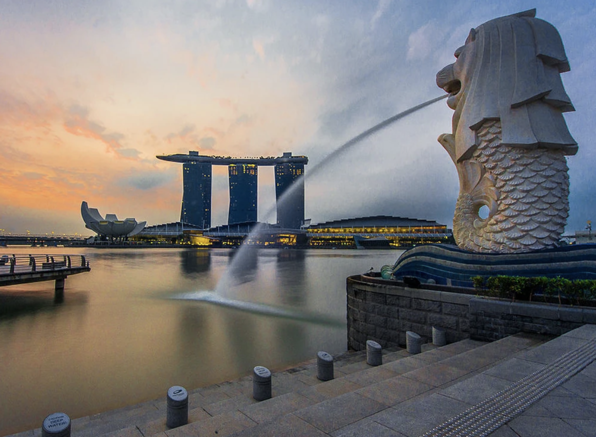

In [187]:
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/LAVIS/assets/merlion.png' 
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')   
display(raw_image.resize((596, 437)))

text = "the statue foutain in front of the lake"
text_input = [text]

In [188]:
# process image and tokenization
inputs = processor(images=raw_image, text=text, return_tensors="pt").to(device, torch.float16)

In [189]:
inputs.keys()

dict_keys(['pixel_values', 'input_ids', 'attention_mask'])

In [190]:
outputs = model(inputs['pixel_values'], inputs['input_ids'], \
                inputs['attention_mask'], decoder_input_ids=inputs['input_ids'], output_attentions=True)

In [162]:
outputs.qformer_outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output', 'attentions', 'cross_attentions'])

In [163]:
len(outputs.qformer_outputs.attentions)

12

In [164]:
outputs.qformer_outputs.attentions[10].size()

torch.Size([1, 12, 32, 32])

In [165]:
outputs.qformer_outputs.attentions[10][0][1]

tensor([[4.2000e-03, 2.9106e-03, 4.2610e-03,  ..., 1.1091e-03, 7.6962e-04,
         6.5708e-04],
        [3.3447e-02, 1.7731e-02, 3.3386e-02,  ..., 3.3131e-03, 1.5230e-03,
         1.3387e-04],
        [5.6572e-03, 1.7939e-03, 1.3359e-02,  ..., 2.7686e-01, 1.6016e-01,
         7.7152e-04],
        ...,
        [6.4087e-02, 1.5402e-03, 8.2336e-02,  ..., 5.7251e-02, 5.0140e-02,
         2.7776e-04],
        [4.8737e-02, 5.9357e-03, 3.0380e-02,  ..., 6.2317e-02, 1.6327e-02,
         3.8648e-04],
        [6.6162e-02, 1.3977e-02, 1.0327e-01,  ..., 9.1457e-04, 1.9140e-03,
         1.4305e-02]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)

In [192]:
tt_mat = torch.stack(outputs.qformer_outputs.attentions).squeeze(1)
tt_mat.size()

torch.Size([12, 12, 32, 32])

In [193]:
# Average the attention weights across all heads.
att_mat = torch.mean(tt_mat, dim=1).cpu().detach()
att_mat.size()

torch.Size([12, 32, 32])

In [194]:
att_mat.device

device(type='cpu')

In [195]:
# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

In [196]:
# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

In [197]:
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, :25].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), raw_image.size)[..., np.newaxis]
result = (mask * raw_image).astype("uint8")

In [198]:
np.min(mask)

0.032881606

In [199]:
raw_mask = np.where(mask < 0.4, 0, 1)

#### image 1

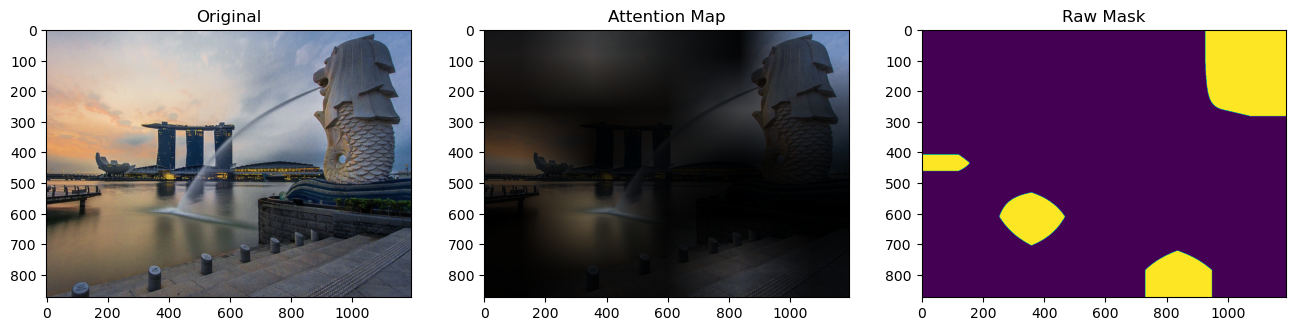

In [200]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
ax3.set_title('Raw Mask')
_ = ax1.imshow(raw_image)
_ = ax2.imshow(result)
_ = ax3.imshow(raw_mask)

#### image 2

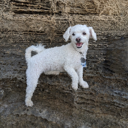

In [94]:
raw_image = Image.open("images/dog_2.jpg")
display(raw_image.resize((128, 128)))
text = "dog"

In [95]:
# process image and tokenization
inputs = processor(images=raw_image, text=text, return_tensors="pt").to(device, torch.float16)
outputs = model(inputs['pixel_values'], inputs['input_ids'], inputs['attention_mask'], \
                decoder_input_ids=inputs['input_ids'], output_attentions=True)

In [96]:
outputs.qformer_outputs.attentions[10][0][1]

tensor([[0.0024, 0.0028, 0.0020,  ..., 0.0029, 0.0018, 0.0003],
        [0.0663, 0.0417, 0.0558,  ..., 0.0064, 0.0035, 0.0004],
        [0.0059, 0.0041, 0.0139,  ..., 0.2756, 0.0815, 0.0017],
        ...,
        [0.0762, 0.0185, 0.1002,  ..., 0.1218, 0.0234, 0.0012],
        [0.0638, 0.0353, 0.0404,  ..., 0.0381, 0.0074, 0.0009],
        [0.0848, 0.0209, 0.1583,  ..., 0.0042, 0.0071, 0.0379]],
       device='cuda:0', dtype=torch.float16, grad_fn=<SelectBackward0>)

In [97]:
tt_mat = torch.stack(outputs.qformer_outputs.attentions).squeeze(1)
tt_mat.size()

torch.Size([12, 12, 32, 32])

In [105]:
# Average the attention weights across all heads.
att_mat = torch.mean(tt_mat, dim=1).cpu().detach()
att_mat.size()

torch.Size([12, 32, 32])

In [99]:
att_mat = outputs.qformer_outputs.attentions[0].squeeze(0).cpu().detach()
att_mat.size()

torch.Size([12, 32, 32])

In [106]:
# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

In [107]:
# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

In [108]:
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, :25].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), raw_image.size)[..., np.newaxis]
result = (mask * raw_image).astype("uint8")

In [109]:
# raw_mask = np.where(mask < 0.3, 0, 1)

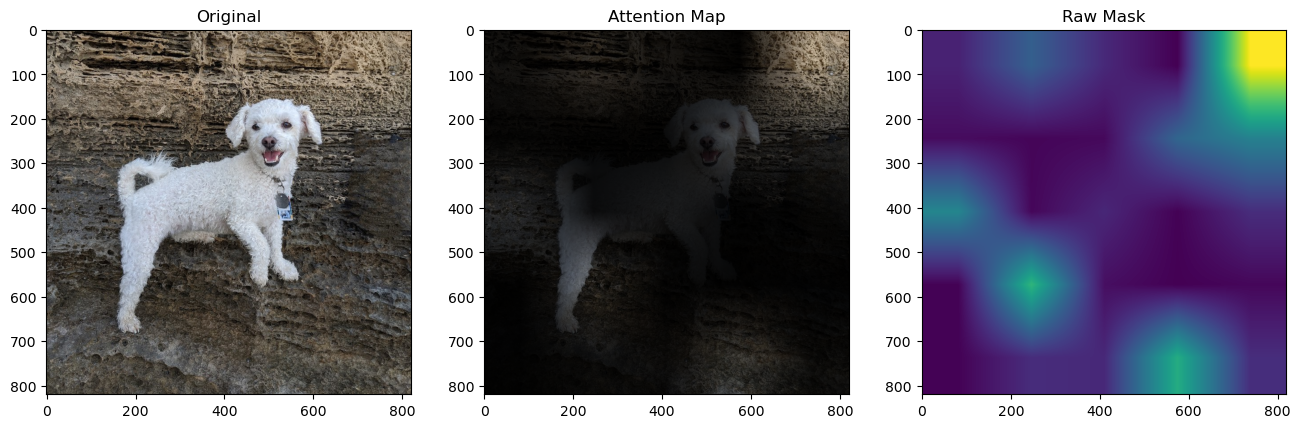

In [110]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
ax3.set_title('Raw Mask')
_ = ax1.imshow(raw_image)
_ = ax2.imshow(result)
_ = ax3.imshow(mask)